# Estimating CPRS

This notebook estimates [Chronos Bolt](https://github.com/amazon-science/chronos-forecasting)'s zero-shot CRPS on each pretraining dataset. Read [this](https://docs.google.com/document/d/1LsKQ9I4i4xLwhiywDrFUkeVAsybitqUAkZ9S9VKRKC4/edit?tab=t.0#heading=h.gz7sst7uli2g) for a more detailed explanation.

<hr>

## Data

### Loading

Load each train-test dataset's time series features and their respective zero-shot CRPS from Chronos-Bolt.

In [43]:
import pandas as pd
from pathlib import Path

split_name = "train_test"
input_path = Path("resources") / split_name / "features.csv"

df = pd.read_csv(input_path)
df.head()

name   term freq  prediction_length     domain     trend   
0  loop_seattle  short   5T                 48  Transport  0.594711  \
1  loop_seattle  short    D                 30  Transport  0.500107   
2  loop_seattle  short    H                 48  Transport  0.446253   
3       m_dense  short    D                 30  Transport  0.729707   
4       m_dense  short    H                 48  Transport  0.397013   

   seasonal_strength   entropy     hurst  stability  lumpiness  true_crps  
0           0.280343  0.589723  0.936951   0.458372   0.613632   0.054599  
1           0.769271  0.576937  0.611051   0.170957   0.339067   0.043734  
2           0.630205  0.656869  0.689547   0.211964   0.454267   0.065010  
3           0.741856  0.681616  0.744518   0.353943   0.367117   0.068998  
4           0.802983  0.477337  0.588340   0.113609   0.155365   0.125025

View the entire DataFrame to see how well Chronos-Bolt's zero-shot CRPS values quantify each dataset's "difficulty".

Here are some things to keep in mind about how time series characteristics affect predictability based on Section 3.2 of the [GIFT-Eval paper](https://arxiv.org/abs/2410.10393):
  - **Prediction length:**
    - Shorter prediction lengths tend to have higher trend and Hurst values. This suggests that shorter forecast horizons may be easier to predict.
  - **Domain:**
    - Healthcare exhibits the highest Hurst and lowest lumpiness values. This suggests they're relatively easier to predict.
    - Econ/Fin shows the highest trend values, indicating strong directional movements that are generally easier to model if the trend is stable.
    - Transport has the highest entropy and lowest trend, indicating low predictability and weak consistent patterns. This may make forecasting  challenging.
    - Web/CloudOps, Sales, and Nature have high lumpiness, meaning they exhibit large fluctuations in variance over time. This'd make them harder to model.
  - **Frequency:**
    - High frequencies like secondly (S) and minutely (T) exhibit the lowest seasonal strengths and poor steadiness. This indicates that they're erratic and volatile, and thus harder to forecast.
    - Mid-frequency data like hourly (H) and daily (D) demonstrate a noticable increase in seasonal strength compared to high frequencies. This suggests they exhibit more stable patterns and would be easier to model.
    - Low frequencies like quarterly (Q) and yearly (A) demonstrate the strongest trends and Hurst values with notably low lumpiness. This indicates they're easier to predict.

In [44]:
pd.set_option("display.max_rows", None)

sorted_df = df.sort_values(by="true_crps", ascending=True).reset_index(drop=True)

display(sorted_df)

name    term freq  prediction_length   
0                       us_births   short    W                  8  \
1                       us_births   short    M                 12   
2                        m4_daily   short    D                 14   
3                       m4_hourly   short    H                 48   
4                       us_births   short    D                 30   
5                    jena_weather   short  10T                 48   
6                       m4_weekly   short    W                 13   
7                    jena_weather   short    H                 48   
8                    loop_seattle   short    D                 30   
9                    jena_weather   short    D                 30   
10                   covid_deaths   short    D                 30   
11                    electricity   short    W                  8   
12               bizitobs_service   short  10S                 60   
13           bizitobs_application   short  10S                 60   
14                   jena_weather  medium    H                480   
15                   loop_seattle   short   5T                 48   
16                    electricity   short    D                 30   
17                       hospital   short    M                 12   
18                   jena_weather  medium  10T                480   
19                   jena_weather    long    H                720   
20                           ett2   short    H                 48   
21                    electricity   short    H                 48   
22                   jena_weather    long  10T                720   
23                   loop_seattle   short    H                 48   
24                           ett2   short  15T                 48   
25                        m_dense   short    D                 30   
26                   bizitobs_l2c   short   5T                 48   
27                   loop_seattle    long    H                720   
28                   loop_seattle  medium    H                480   
29                   m4_quarterly   short    Q                  8   
30                    electricity  medium    H                480   
31                    electricity   short  15T                 48   
32                    electricity  medium  15T                480   
33                    electricity    long  15T                720   
34                           ett2   short    W                  8   
35                           ett2   short    D                 30   
36                     m4_monthly   short    M                 18   
37               bizitobs_service  medium  10S                600   
38                    electricity    long    H                720   
39           bizitobs_application  medium  10S                600   
40           bizitobs_application    long  10S                900   
41                           ett2  medium  15T                480   
42                           ett2    long  15T                720   
43               bizitobs_service    long  10S                900   
44                           ett2  medium    H                480   
45                   loop_seattle  medium   5T                480   
46                           ett2    long    H                720   
47                      m4_yearly   short    A                  6   
48                        m_dense   short    H                 48   
49                   loop_seattle    long   5T                720   
50                          solar   short    W                  8   
51                        sz_taxi   short    H                 48   
52                        m_dense  medium    H                480   
53                           ett1   short  15T                 48   
54                        m_dense    long    H                720   
55                           ett1   short    H                 48   
56                   bizitobs_l2c   short    H                 48   
57                        s

Plot each time series feature as a function of CRPS score indices in the sorted DataFrame.

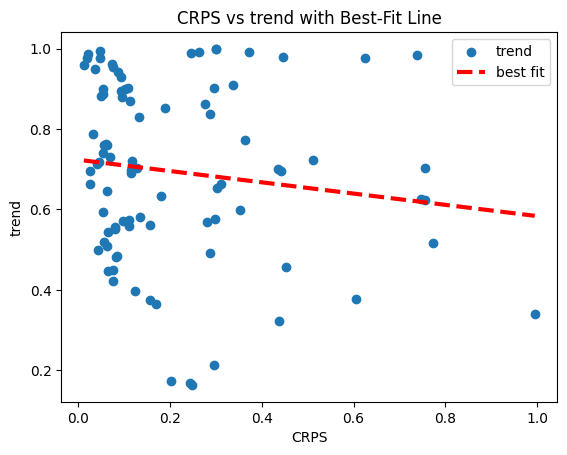

Params: [ 0.72356193 -0.14017463]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.592
Date:                Fri, 20 Jun 2025   Prob (F-statistic):              0.210
Time:                        18:25:24   Log-Likelihood:                 9.0609
No. Observations:                  90   AIC:                            -14.12
Df Residuals:                      88   BIC:                            -9.122
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7

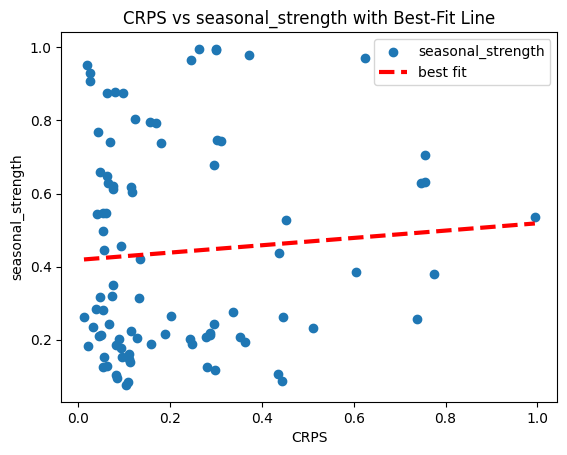

Params: [0.41825303 0.10036754]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.4795
Date:                Fri, 20 Jun 2025   Prob (F-statistic):              0.490
Time:                        18:25:24   Log-Likelihood:                -14.878
No. Observations:                  90   AIC:                             33.76
Df Residuals:                      88   BIC:                             38.76
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.418

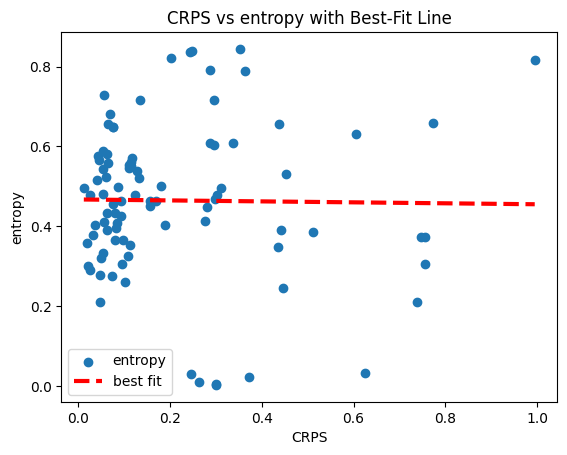

Params: [ 0.46736825 -0.01207076]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                   0.01536
Date:                Fri, 20 Jun 2025   Prob (F-statistic):              0.902
Time:                        18:25:24   Log-Likelihood:                 20.894
No. Observations:                  90   AIC:                            -37.79
Df Residuals:                      88   BIC:                            -32.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4

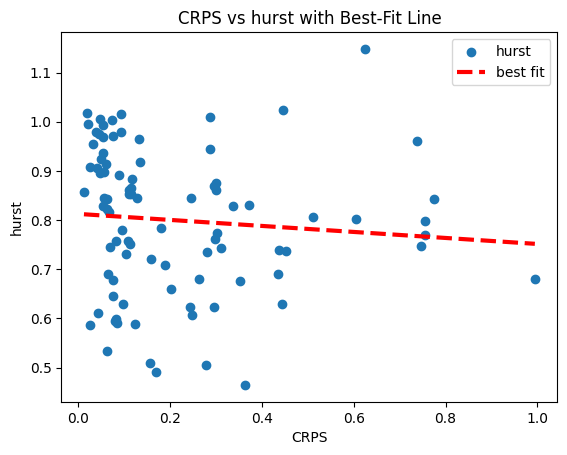

Params: [ 0.81260184 -0.06120918]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.6871
Date:                Fri, 20 Jun 2025   Prob (F-statistic):              0.409
Time:                        18:25:24   Log-Likelihood:                 45.818
No. Observations:                  90   AIC:                            -87.64
Df Residuals:                      88   BIC:                            -82.64
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8

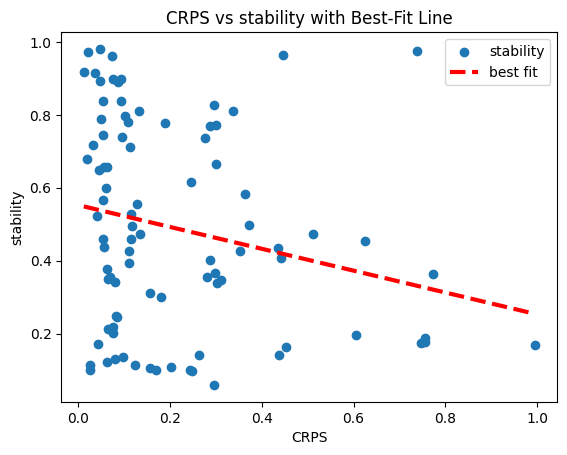

Params: [ 0.55272897 -0.30026562]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     4.698
Date:                Fri, 20 Jun 2025   Prob (F-statistic):             0.0329
Time:                        18:25:24   Log-Likelihood:                -10.807
No. Observations:                  90   AIC:                             25.61
Df Residuals:                      88   BIC:                             30.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5

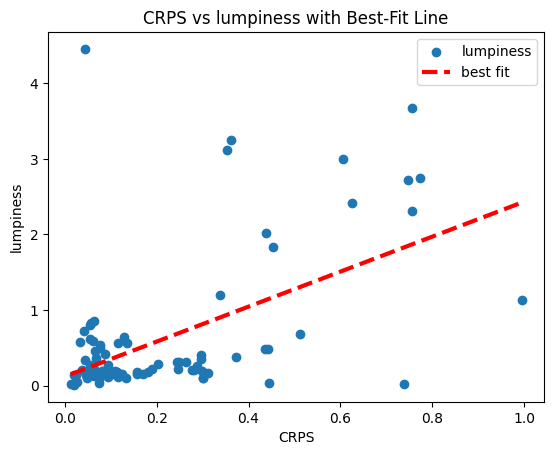

Params: [0.12011514 2.3133834 ]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     35.42
Date:                Fri, 20 Jun 2025   Prob (F-statistic):           5.30e-08
Time:                        18:25:24   Log-Likelihood:                -103.66
No. Observations:                  90   AIC:                             211.3
Df Residuals:                      88   BIC:                             216.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.120

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm


features = [
    "trend",
    "seasonal_strength",
    "entropy",
    "hurst",
    "stability",
    "lumpiness",
]

sorted_df = sorted_df.dropna()

for feature in features:
    x = sorted_df["true_crps"].values
    y = sorted_df[feature].values

    coeffs = np.polyfit(x, y, deg=1)
    fit_fn = np.poly1d(coeffs)

    plt.figure()
    plt.scatter(x, y, label=feature)
    plt.plot(x, fit_fn(x), "--", color="red", linewidth=3, label="best fit")

    plt.title(f"CRPS vs {feature} with Best-Fit Line")
    plt.xlabel("CRPS")
    plt.ylabel(feature)
    plt.legend()
    plt.grid(False)
    plt.show()

    model = sm.OLS(y, sm.add_constant(x))
    results = model.fit()

    print(f'Params: {results.params}')
    print(results.summary())

### Preprocessing

#### `NaN`s 

Check if there are any rows with one or more `NaN`s in the time series feature columns.

In [31]:
from IPython.display import display

df_nan = df[df.isnull().any(axis=1)].reset_index(drop=True)

print(f"Number of rows with NaNs in time series features: {len(df_nan)}")

print("Datasets with missing features:")
for index, row in df_nan.iterrows():
    print(f"  {row['name']}/{row['freq']} ({row['term']})")

display(df_nan)

Number of rows with NaNs in time series features: 7
Datasets with missing features:
  hierarchical_sales/D (short)
  m4_yearly/A (short)
  solar/H (short)
  temperature_rain_with_missing/D (short)
  bizitobs_l2c/H (medium)
  solar/H (medium)
  solar/H (long)


name    term freq  prediction_length   
0             hierarchical_sales   short    D                 30  \
1                      m4_yearly   short    A                  6   
2                          solar   short    H                 48   
3  temperature_rain_with_missing   short    D                 30   
4                   bizitobs_l2c  medium    H                480   
5                          solar  medium    H                480   
6                          solar    long    H                720   

         domain     trend  seasonal_strength   entropy     hurst  stability   
0         Sales  1.000000           1.000000  0.000000       NaN        NaN  \
1      Econ/Fin  0.942347                NaN  0.499465  0.957853   0.811223   
2        Energy  0.392161           0.887099  0.411896       NaN   0.060786   
3        Nature       NaN                NaN       NaN       NaN        NaN   
4  Web/CloudOps  0.860124           0.203657  0.413234       NaN   0.736321   
5        Energy  0.396826           0.880060  0.410616       NaN   0.064802   
6        Energy  0.391212           0.850250  0.422815       NaN   0.077194   

   lumpiness  true_crps  
0        NaN   0.576119  
1   0.101500   0.121485  
2   0.280778   0.297931  
3        NaN   0.537715  
4   0.202554   0.254430  
5   0.295527   0.368472  
6   0.347750   0.405166

Remove rows with one or more `NaN`s in the time series feature columns.

In [ ]:
initial_rows = len(df)
df = df.dropna(subset=features)
num_dropped = initial_rows - len(df)
print(f"Number of rows dropped: {num_dropped}")

Number of rows dropped: 7


#### Domains

Use an [ordinal encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder) to encode each domain as an integer.

In [33]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()

df["domain"] = enc.fit_transform(df[["domain"]])
df.head()

name   term freq  prediction_length  domain     trend   
0  loop_seattle  short   5T                 48     5.0  0.594711  \
1  loop_seattle  short    D                 30     5.0  0.500107   
2  loop_seattle  short    H                 48     5.0  0.446253   
3       m_dense  short    D                 30     5.0  0.729707   
4       m_dense  short    H                 48     5.0  0.397013   

   seasonal_strength   entropy     hurst  stability  lumpiness  true_crps  
0           0.280343  0.589723  0.936951   0.458372   0.613632   0.054599  
1           0.769271  0.576937  0.611051   0.170957   0.339067   0.043734  
2           0.630205  0.656869  0.689547   0.211964   0.454267   0.065010  
3           0.741856  0.681616  0.744518   0.353943   0.367117   0.068998  
4           0.802983  0.477337  0.588340   0.113609   0.155365   0.125025

#### Frequencies

Encode each frequency as its corresponding number of preiods per year.

In [34]:
import numpy as np
import re

SECONDS_PER_YEAR = 365 * 24 * 60 * 60


def freq_to_seconds(freq_str: str) -> float:
    """
    Convert a frequency string (e.g., 'T', '15T', etc.) into its equivalent
    duration in seconds.

    The function extracts a optional numeric multiplier and a time unit from
    the input string and calculates the total duration in seconds based on a
    predefined mapping of time units.

    Supported units:
    - 'S' : second
    - 'T' : minute (60 seconds)
    - 'H' : hour (3600 seconds)
    - 'D' : day (86400 seconds)
    - 'W' : week (604800 seconds)
    - 'M' : month (approximated as 30 days)
    - 'Q' : quarter (approximated as 91 days)
    - 'Y' : year (approximated as 365 days)

    Args:
        freq_str (str): A frequency string composed of:
        - An optional 1-2 digit integer
        - An uppercase time unit.

    Returns:
        float: The equivalent number of seconds, or np.nan if the format is
            invalid.
    """
    match = re.match(r"^(\d{1,2})?([A-Z]+)", freq_str)
    if not match:
        return np.nan

    num_str, freq = match.groups()
    num = int(num_str) if num_str is not None else 1

    freq_map = {
        "S": 1,
        "T": 60,  # minute
        "H": 3600,
        "D": 86400,
        "W": 7 * 86400,
        "M": 30 * 86400,
        "Q": 91 * 86400,
        "Y": 365 * 86400,
    }

    if freq not in freq_map:
        return np.nan

    return num * freq_map[freq]


def freq_to_periods(freq_str: str) -> float:
    """
    Convert a frequency string into the approximate number of periods per year.

    Example:
    - 'D' -> 365 (daily)
    - 'H' -> 8760 (hourly)
    - 'Q' -> ~4.01 (quarterly)
    - '5T' -> 105120 (every 5 minutes)

    Args:
        freq_str (str): A frequency string composed of an optional numeric
        prefix (up to 2 digits) followed by a time unit (e.g., '5T', 'Q',
        'D').

    Returns:
        float: Approximate number of periods per year for the given frequency.
            Returns np.nan if the input is invalid or cannot be parsed.
    """
    seconds = freq_to_seconds(freq_str)
    return np.nan if pd.isna(seconds) else SECONDS_PER_YEAR / seconds


df["freq"] = df["freq"].apply(freq_to_periods)
df.head()

name   term      freq  prediction_length  domain     trend   
0  loop_seattle  short  105120.0                 48     5.0  0.594711  \
1  loop_seattle  short     365.0                 30     5.0  0.500107   
2  loop_seattle  short    8760.0                 48     5.0  0.446253   
3       m_dense  short     365.0                 30     5.0  0.729707   
4       m_dense  short    8760.0                 48     5.0  0.397013   

   seasonal_strength   entropy     hurst  stability  lumpiness  true_crps  
0           0.280343  0.589723  0.936951   0.458372   0.613632   0.054599  
1           0.769271  0.576937  0.611051   0.170957   0.339067   0.043734  
2           0.630205  0.656869  0.689547   0.211964   0.454267   0.065010  
3           0.741856  0.681616  0.744518   0.353943   0.367117   0.068998  
4           0.802983  0.477337  0.588340   0.113609   0.155365   0.125025

<hr>

## XGBoost Tree

### Training

We're going to train an [XGBoost tree](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor) on each train-test dataset's time series features to predict Chronos-Bolt's CRPS on the dataset.

1. Split the DataFrame into a training split and a test split.

In [35]:
from sklearn.model_selection import train_test_split


X, y = df[features], df["true_crps"]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

print(f"X columns: {X_train.columns.tolist()}")
print(f"y column: {y_train.name}")

X columns: ['trend', 'seasonal_strength', 'entropy', 'hurst', 'stability', 'lumpiness']
y column: true_crps


2. Use [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#gridsearchcv) and [leave-one-out cross-validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html) to perform hyperparameter optimization.

In [36]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, LeaveOneOut

# TODO: Consider playing around with params to decrease CV MSE
param_grid = {
    "max_depth": [3, 5],
    "learning_rate": [0.01, 0.1],
    "n_estimators": [100, 200],
}
grid = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    cv=LeaveOneOut(),
    scoring="neg_mean_squared_error",
    verbose=1,
).fit(X_train, y_train)

print(f"[Grid Search] Best parameters: {grid.best_params_}")
print(f"[Grid Search] Best cross-validation MSE: {-grid.best_score_:.3f}")

Fitting 72 folds for each of 8 candidates, totalling 576 fits
[Grid Search] Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
[Grid Search] Best cross-validation MSE: 0.033


3. Save the best XGBoost tree.

In [37]:
estimator_path = Path("xgboost") / split_name / "crps.json"
estimator_path.parent.mkdir(parents=True, exist_ok=True)

print(f"Saving best XGBoost tree to: {estimator_path}")
estimator = grid.best_estimator_
estimator.save_model(str(estimator_path))

Saving best XGBoost tree to: xgboost\train_test\crps.json


4. Compare the best XGBoost tree to training and evaluating a [dummy model](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html#sklearn.dummy.DummyRegressor)

In [38]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error


dummy = DummyRegressor().fit(X_train, y_train)
base_mse = mean_squared_error(y_test, dummy.predict(X_test))
print(f"[Dummy] Test MSE: {base_mse:.3f}")

y_pred = estimator.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"[XGBoost] Test MSE: {mse:.3f}")

[Dummy] Test MSE: 0.047
[XGBoost] Test MSE: 0.005


5. Plot each feature's [importance](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.plot_importance) in predicting Chronos-Bolt's CRPS.

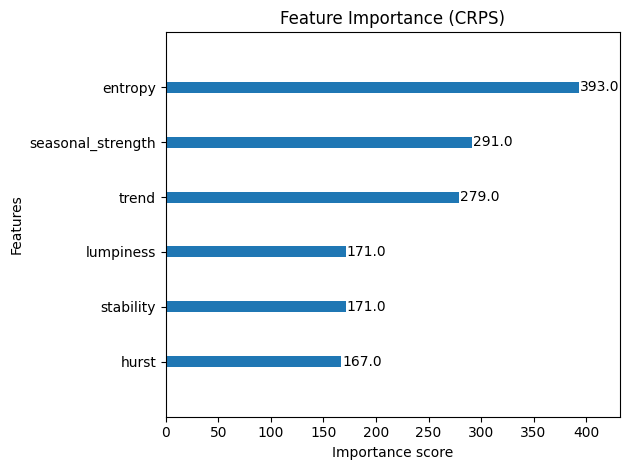

In [39]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

ax = plot_importance(estimator)
ax.set_title("Feature Importance (CRPS)")
ax.grid(False)
plt.tight_layout()

plot_dirpath = Path("plots") / "xgboost" / split_name
plot_path = plot_dirpath / "crps_importance.png"
plot_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(plot_path, dpi=300)
plt.show()

### Inference

Now that we've trained our XGBoost tree, we can use it to estimate Chronos-Bolt's CRPS each pretraining dataset.

Load each pretraining dataset's time series features.

In [45]:
split_name = "pretrain"
input_path = Path("resources") / split_name / "features.csv"

df = pd.read_csv(input_path)
df.head()

name    term freq  prediction_length   domain     trend   
0        bull   short    H                 48   Energy  0.782879  \
1        bull  medium    H                480   Energy  0.787341   
2        bull    long    H                720   Energy  0.787341   
3  cmip6_1885   short   6H                 48  Climate  0.771910   
4  cmip6_1885  medium   6H                480  Climate  0.771910   

   seasonal_strength   entropy     hurst  stability  lumpiness  pred_crps  
0           0.643668  0.421485  0.877564   0.561245   0.861113   0.112148  
1           0.676362  0.384731  0.856679   0.561245   0.504205   0.112148  
2           0.676362  0.384731  0.864038   0.561245   0.424739   0.112148  
3           0.569295  0.394264  0.942279   0.381861   0.308085   0.112148  
4           0.601990  0.432520  0.942279   0.381861   0.308085   0.112148

Remove irrelvant columns for inference.

In [46]:
X = df[features]

X.head()

trend  seasonal_strength   entropy     hurst  stability  lumpiness
0  0.782879           0.643668  0.421485  0.877564   0.561245   0.861113
1  0.787341           0.676362  0.384731  0.856679   0.561245   0.504205
2  0.787341           0.676362  0.384731  0.864038   0.561245   0.424739
3  0.771910           0.569295  0.394264  0.942279   0.381861   0.308085
4  0.771910           0.601990  0.432520  0.942279   0.381861   0.308085

Use the trained XGBoost tree to predict Chronos-Bolt's CRPS on each pretraining dataset.

In [47]:
xgb_dirpath = Path("xgboost") / "train_test"

estimator = XGBRegressor()
estimator.load_model(xgb_dirpath / "crps.json")

y_pred = estimator.predict(X)
df["pred_crps"] = y_pred

features_path = input_path.parent / "features.csv"
df.to_csv(features_path, index=False)
df.head()

name    term freq  prediction_length   domain     trend   
0        bull   short    H                 48   Energy  0.782879  \
1        bull  medium    H                480   Energy  0.787341   
2        bull    long    H                720   Energy  0.787341   
3  cmip6_1885   short   6H                 48  Climate  0.771910   
4  cmip6_1885  medium   6H                480  Climate  0.771910   

   seasonal_strength   entropy     hurst  stability  lumpiness  pred_crps  
0           0.643668  0.421485  0.877564   0.561245   0.861113   0.112148  
1           0.676362  0.384731  0.856679   0.561245   0.504205   0.112148  
2           0.676362  0.384731  0.864038   0.561245   0.424739   0.112148  
3           0.569295  0.394264  0.942279   0.381861   0.308085   0.112148  
4           0.601990  0.432520  0.942279   0.381861   0.308085   0.112148

Count the number of unique CRPS scores across the pretraining split.

In [48]:
df["pred_crps"].nunique()

20

View the datasets whose predicted CRPS score is equal to the mode.

In [ ]:
mode_value = df["pred_crps"].mode().iloc[0]
df_mode_rows = df[df["pred_crps"] == mode_value]
display(df_mode_rows)

name    term freq  prediction_length   
0                                bull   short    H                 48  \
1                                bull  medium    H                480   
2                                bull    long    H                720   
3                          cmip6_1885   short   6H                 48   
4                          cmip6_1885  medium   6H                480   
5                          cmip6_1885    long   6H                720   
18                         gfc12_load   short    H                 48   
19                         gfc12_load  medium    H                480   
20                         gfc12_load    long    H                720   
21                     buildings_900k   short    H                 48   
22                     buildings_900k  medium    H                480   
23                     buildings_900k    long    H                720   
24   london_smart_meters_with_missing   short  30T                 48   
25   london_smart_meters_with_missing  medium  30T                480   
26   london_smart_meters_with_missing    long  30T                720   
31                           pems_bay  medium   5T                480   
36                         cmip6_1975   short   6H                 48   
37                         cmip6_1975  medium   6H                480   
38                         cmip6_1975    long   6H                720   
39                         elecdemand   short  30T                 48   
40                         elecdemand  medium  30T                480   
41                         elecdemand    long  30T                720   
45                              spain   short    H                 48   
46                              spain  medium    H                480   
47                              spain    long    H                720   
63                         cmip6_1930   short   6H                 48   
64                         cmip6_1930  medium   6H                480   
65                         cmip6_1930    long   6H                720   
72                         cmip6_1940   short   6H                 48   
73                         cmip6_1940  medium   6H                480   
74                         cmip6_1940    long   6H                720   
75                          bdg-2_rat   short    H                 48   
76                          bdg-2_rat  medium    H                480   
77                          bdg-2_rat    long    H                720   
82                       largest_2020  medium   5T                480   
84                         cmip6_1875   short   6H                 48   
85                         cmip6_1875  medium   6H                480   
86                         cmip6_1875    long   6H                720   
87                         cmip6_1905   short   6H                 48   
88                         cmip6_1905  medium   6H                480   
89                         cmip6_1905    long   6H                720   
100                      largest_2018  medium   5T                480   
103                            pems07  medium   5T                480   
114                     bdg-2_panther   short    H                 48   
115                     bdg-2_panther  medium    H                480   
116                     bdg-2_panther    long    H                720   
117                        cmip6_1985   short   6H                 48   
118                        cmip6_1985  medium   6H                480   
119                        cmip6_1985    long   6H                720   
123              bitcoin_with_missing   short    D                 30   
124              bitcoin_with_missing  medium    D                300   
125              bitcoin_with_missing    long    D                450   
135                        cmip6_1965   short   6H                 48   
136                        cmip6_1965  medium   6H                480   
137               

<br>